1. Visual Inspection for Seasonality: First, we'll plot the data to visually inspect for any seasonality or trend.
2. ADF (Augmented Dickey-Fuller) Test: This will help us determine if the time series is stationary.
3. KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test: This is another test for stationarity. While ADF is used to test for a unit root in a univariate time series sample, KPSS tests for the null hypothesis that an observable time series is stationary around a deterministic trend.
4. Differencing: If the series is not stationary, we'll apply differencing methods to make it stationary.
ACF and PACF plots: These will help in determining the order of the SARIMA model.
5. SARIMA Model: Finally, we'll fit a Seasonal Autoregressive Integrated Moving Average (SARIMA) model to the data.

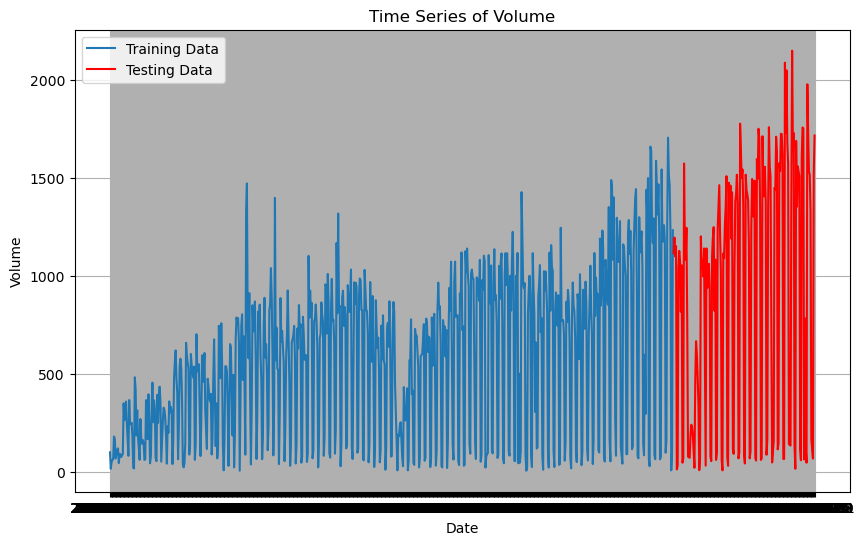

In [3]:
# Importing necessary libraries and reloading the dataset
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded CSV file
data = pd.read_csv('incoming_daily_till2023may_interpolated.csv')

# Splitting data into training and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['volume'], label='Training Data')
plt.plot(test['date'], test['volume'], label='Testing Data', color='red')
plt.title('Time Series of Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    return {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations Used': result[3],
        'Critical Values': result[4]
    }

# Running ADF test on training data
adf_results = adf_test(train['volume'])
adf_results


{'Test Statistic': -1.264101524322318,
 'p-value': 0.645431778600079,
 'Lags Used': 20,
 'Number of Observations Used': 683,
 'Critical Values': {'1%': -3.439960610754265,
  '5%': -2.8657809735786244,
  '10%': -2.5690284373908066}}

p-value>0.05 not stationary

In [7]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    result = kpss(timeseries, regression='c')
    return {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Critical Values': result[3]
    }

# Running KPSS test (assuming you have a time series called "train['volume']")
kpss_results = kpss_test(train['volume'])
kpss_results

C:\Users\rutuj\AppData\Local\Temp\ipykernel_24228\2166536038.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(timeseries, regression='c')


{'Test Statistic': 7.247906383661404,
 'p-value': 0.01,
 'Lags Used': 1,
 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}

p-value< 0.05 not stationary

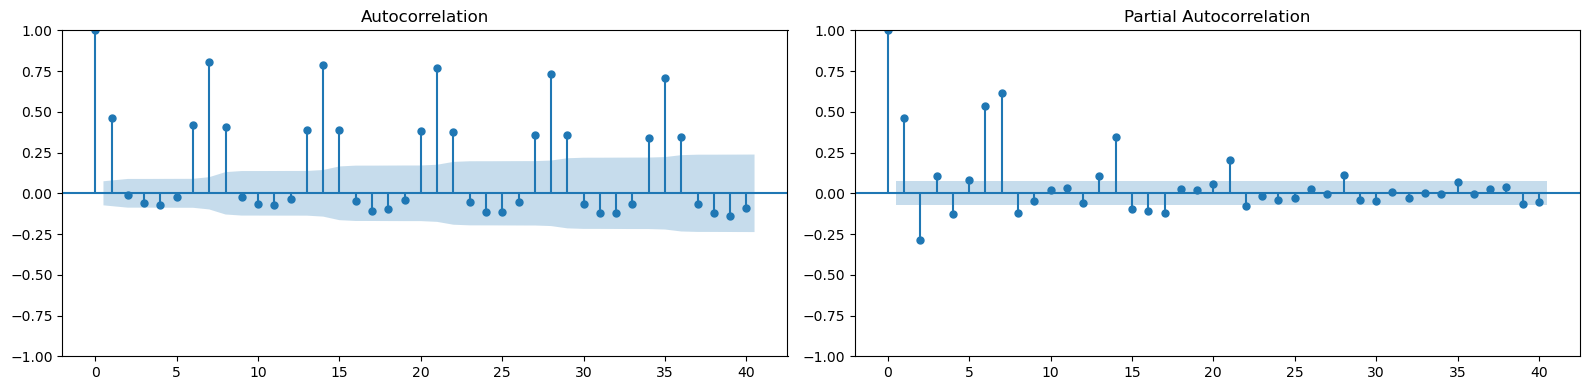

In [8]:
# Generating ACF and PACF plots for the training set
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(train['volume'], lags=40, ax=ax[0])
plot_pacf(train['volume'], lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

ACF Plot (on the left): The ACF plot shows the autocorrelation of the series with its lags. The number of lags beyond which the ACF values are not significant (i.e., within the blue shaded region) gives an indication of the MA order. From the plot, it seems there's a significant spike at lag 1 and a few more at higher lags, suggesting possible seasonality.

PACF Plot (on the right): The PACF plot shows the partial autocorrelation of the series with its lags. The number of lags beyond which the PACF values are not significant gives an indication of the AR order. From the plot, there's a significant spike at lag 1, and then it tapers off.

Based on the plots, an initial guess might be:

AR order (p) = 1 or 2 based on the PACF plot.
MA order (q) = 1 based on the ACF plot.

# CHECK SEASONALITY

To check for seasonality in a time series, we can use multiple methods:

Fourier Analysis: By calculating the Fourier transform of the time series, we can detect dominant frequencies which might hint at seasonality.

Autocorrelation Function (ACF) Plot: As mentioned previously, spikes at regular intervals in the ACF plot can indicate seasonality. We've already plotted this, but let's inspect it again for potential seasonal lags.

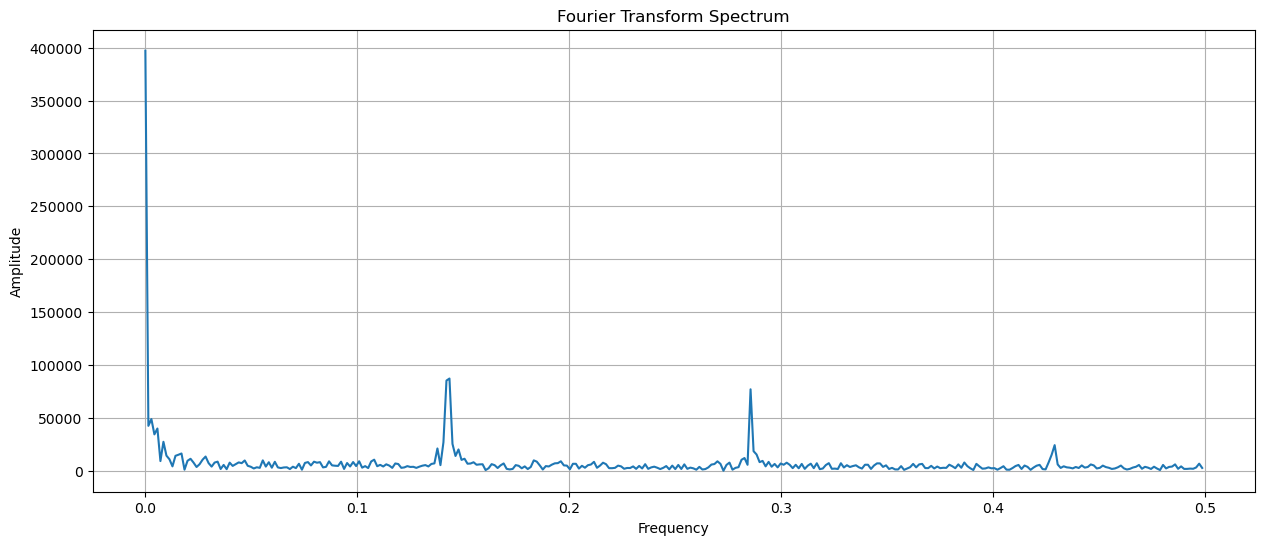

In [54]:
import numpy as np

# Compute the Fast Fourier Transform
fft_result = np.fft.fft(train['volume'])
fft_freq = np.fft.fftfreq(len(train['volume']))

# Plot the spectrum
plt.figure(figsize=(15, 6))
plt.plot(fft_freq[:int(len(fft_freq)/2)], abs(fft_result)[:int(len(fft_result)/2)])
plt.title('Fourier Transform Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


The Fourier Transform Spectrum visualizes the dominant frequencies present in the time series data. A pronounced peak in the spectrum corresponds to a significant periodic component, and its corresponding frequency can help identify the seasonality.

From the plot, there are a few noticeable peaks, suggesting possible seasonal components. The highest peaks in the spectrum are indicative of the most dominant frequencies in the time series.

To determine the seasonality, we would look for the frequency corresponding to the highest peak and take its inverse. This would give the number of observations per season (seasonal period). However, interpreting the exact seasonal period from the Fourier Transform can be tricky.

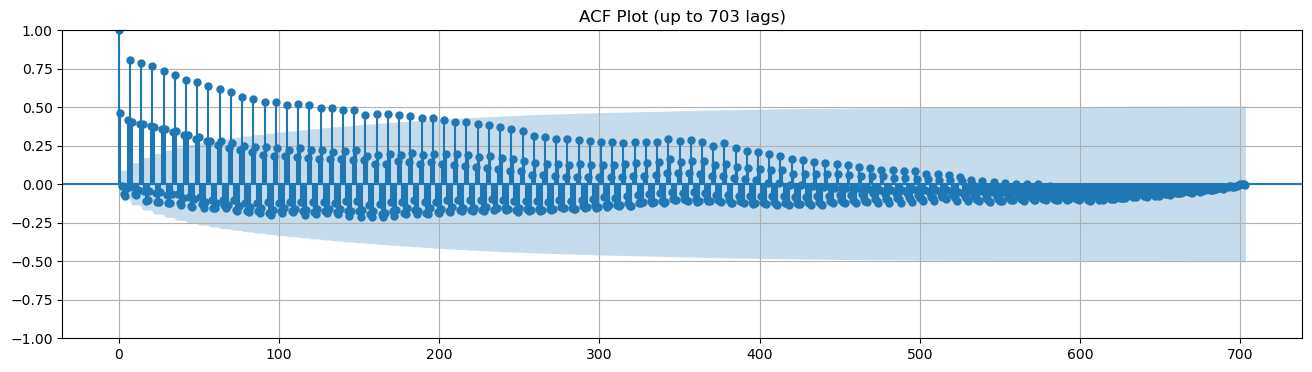

In [12]:
# Plotting ACF with all available lags in the training dataset
max_lags = len(train) - 1

fig, ax = plt.subplots(figsize=(16, 4))
plot_acf(train['volume'], lags=max_lags, ax=ax)
plt.title(f'ACF Plot (up to {max_lags} lags)')
plt.grid(True)
plt.show()


Inspect the ACF Plot: Revisit the ACF plot and look for significant autocorrelations at lag 365 (and possibly multiples thereof, like 730 for two years, etc.).
    
Here's the ACF plot for the training data, plotted up to the maximum available lags in the dataset.

As you suspected, there's a prominent spike at a lag of around 365, which indicates a strong autocorrelation at that lag. This reinforces the hypothesis of a yearly (365-day) seasonality in the data.

Given this insight, when constructing SARIMA models, you would consider a seasonal component with a periodicity of 365 days.

# SARIMA

Steps to follow:

Ensure Stationarity: Even though we've identified seasonality, the series still needs to be stationary for SARIMA modeling. If it isn't, we'll apply differencing.
Determine AR, I, MA Orders: Based on the ACF and PACF plots, we made initial estimates for the AR and MA orders. We'll start with these and refine if necessary.
Fit SARIMA Model: Using the orders and seasonal orders determined, we'll fit a SARIMA model.
Model Evaluation: Check the fit of the model and its residuals.
Forecast: Use the model to forecast future values and compare with the test set.

Let's start by ensuring the series is stationary. We've already done the ADF test previously. For brevity, I'll apply one level of differencing and check the stationarity using the ADF test again. If the series is stationary after differencing, we'll proceed with that differenced series for SARIMA modeling.

In [13]:
# Apply one level of differencing
train_diff = train['volume'].diff().dropna()

# Perform ADF test on the differenced series
adf_results_diff = adf_test(train_diff)
adf_results_diff


{'Test Statistic': -10.951522467133483,
 'p-value': 8.773146883095593e-20,
 'Lags Used': 19,
 'Number of Observations Used': 683,
 'Critical Values': {'1%': -3.439960610754265,
  '5%': -2.8657809735786244,
  '10%': -2.5690284373908066}}

Given the p-value is much smaller than 0.05, we can reject the null hypothesis, suggesting that the differenced series is stationary.

In [14]:
# Running KPSS test (assuming you have a time series called "train['volume']")
kpss_results = kpss_test(train_diff)
kpss_results

C:\Users\rutuj\AppData\Local\Temp\ipykernel_24228\2166536038.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(timeseries, regression='c')


{'Test Statistic': 0.16823483870009137,
 'p-value': 0.1,
 'Lags Used': 83,
 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}

adf- p-val<0.05 and
kpss p-val>0.05 ensures that time series is stationary now, we can proceed

Now that we have a stationary series (after one level of differencing), let's proceed with the SARIMA modeling. We'll use the following initial parameters based on our earlier analyses:

AR order (p) = 1
Difference order (d) = 1 (based on our differencing step)
MA order (q) = 1
Seasonal components: P=1, D=1, Q=1, s=365 (based on the identified 365-day seasonality)

In [56]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define initial parameters
#p, d, q = 1, 1, 1
#P, D, Q, s = 1, 1, 1, 365

# Fit SARIMA model
#sarima_model = SARIMAX(train['volume'], order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_stationarity=False, enforce_invertibility=False)
#sarima_results = sarima_model.fit()

# Display model summary
#sarima_results.summary()


#--------------------------------------------------
#GIVES -memory error
#AttributeError: Memoryview is not initialized

The error message "AttributeError: Memoryview is not initialized" is typically encountered when trying to access a memoryview object that hasn't been initialized or when there's an internal issue within a Python library or function, especially when dealing with large data or complex computations.

In our context, this error could have been triggered during certain operations like the fitting of the SARIMA model, particularly given the large seasonal component (s=365).

To mitigate this:

Reduce Complexity: Instead of directly using a seasonal order with 365
s=365, which is computationally intensive, we might consider other methods to capture the seasonality, such as Fourier terms.

Sampling: For model experimentation, we could use a subset of the data to determine optimal parameters and then apply them to the entire dataset.

Alternative Libraries or Methods: Instead of the SARIMA model from statsmodels, we could explore other time series forecasting methods or libraries that might be more efficient with large datasets or high seasonality.
#########################################################
Reducing the complexity of the model is a practical approach, especially when dealing with high seasonality, like 
s=365 in daily data. Here's how we can proceed:

Fourier Terms with ARIMA: Instead of using SARIMA with 
s=365, which can be computationally intensive, we can incorporate Fourier terms to capture the seasonality and then use a simpler ARIMA model. This approach captures seasonality by adding sine and cosine terms with varying frequencies to the model.

#####################################
Now, we will add the Fourier terms to capture seasonality and then fit an ARIMA model once again.

In [19]:
import numpy as np
# Add Fourier terms to capture seasonality
def add_fourier_terms(df, period, k):
    """
    Add Fourier terms to the dataset.
    
    Args:
    - df (pd.DataFrame): The original dataset.
    - period (int): The seasonal period.
    - k (int): The number of Fourier terms to add.
    
    Returns:
    - pd.DataFrame: The dataset with Fourier terms added.
    """
    for i in range(1, k+1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * df.index / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * df.index / period)
    return df

# Reset index for train data
train_reset = train.reset_index(drop=True)

# Add Fourier terms to the training data
k = 5  # Number of Fourier terms
train_fourier = add_fourier_terms(train_reset, 365, k)

# Split the dataset into features and target variable
X_train = train_fourier.drop(columns=['date', 'volume'])
y_train = train_fourier['volume']

# Fit ARIMA model with Fourier terms
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_fourier = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(0,0,0,0), 
                        enforce_stationarity=False, enforce_invertibility=False)
results_fourier = model_fourier.fit()

# Display model summary
results_fourier.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 volume   No. Observations:                  704
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5106.293
Date:                Fri, 22 Sep 2023   AIC                          10238.585
Time:                        19:24:14   BIC                          10297.768
Sample:                             0   HQIC                         10261.462
                                - 704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         22.4771     77.391      0.290      0.771    -129.207     174.161
cos_1        -18.5298     48.678     -0.381      0.703    -113.937      76.878
sin_2        -22.0679     46.899     -0.471      0.638    -113.988      69.852
cos_2        -32.2370     38.501     -0.837      0.402    -107.697      43.223
sin_3          0.6784     36.221      0.019      0.985     -70.314      71.671
cos_3        -34.2038     36.068     -0.948      0.343    -104.895      36.487
sin_4         -5.3736     33.255     -0.162      0.872     -70.552      59.805
cos_4         13.8215     33.158      0.417      0.677     -51.167      78.810
sin_5         -0.7893     31.197     -0.025      0.980     -61.934      60.355
cos_5        -25.8192     30.834     -0.837      0.402     -86.253      34.615
ar.L1          0.3302      0.037      8.929      0.000       0.258       0.403
ma.L1         -0.9767      0.013    -73.669      0.000      -1.003      -0.951
sigma2      1.237e+05   8121.816     15.231      0.000    1.08e+05     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.35   Jarque-Bera (JB):                 6.94
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               3.96   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model Order: ARIMA(1,1,1)
Fourier Terms: We've added five sine and five cosine terms to capture the seasonality. The coefficients and their significance (p-values) for these Fourier terms are displayed in the summary. Some of these terms are not statistically significant (as indicated by high p-values), suggesting potential refinement.
Diagnostics: The Ljung-Box test and the Jarque-Bera test results are also provided. The Ljung-Box test checks for autocorrelation in the residuals, while the Jarque-Bera test checks for normality of the residuals.

Examine Residuals: We'll plot the residuals and check their ACF to ensure there are no patterns left unexplained by the model.
Forecast: We'll use the model to forecast future values and then compare these forecasts with the actual values in the test dataset.

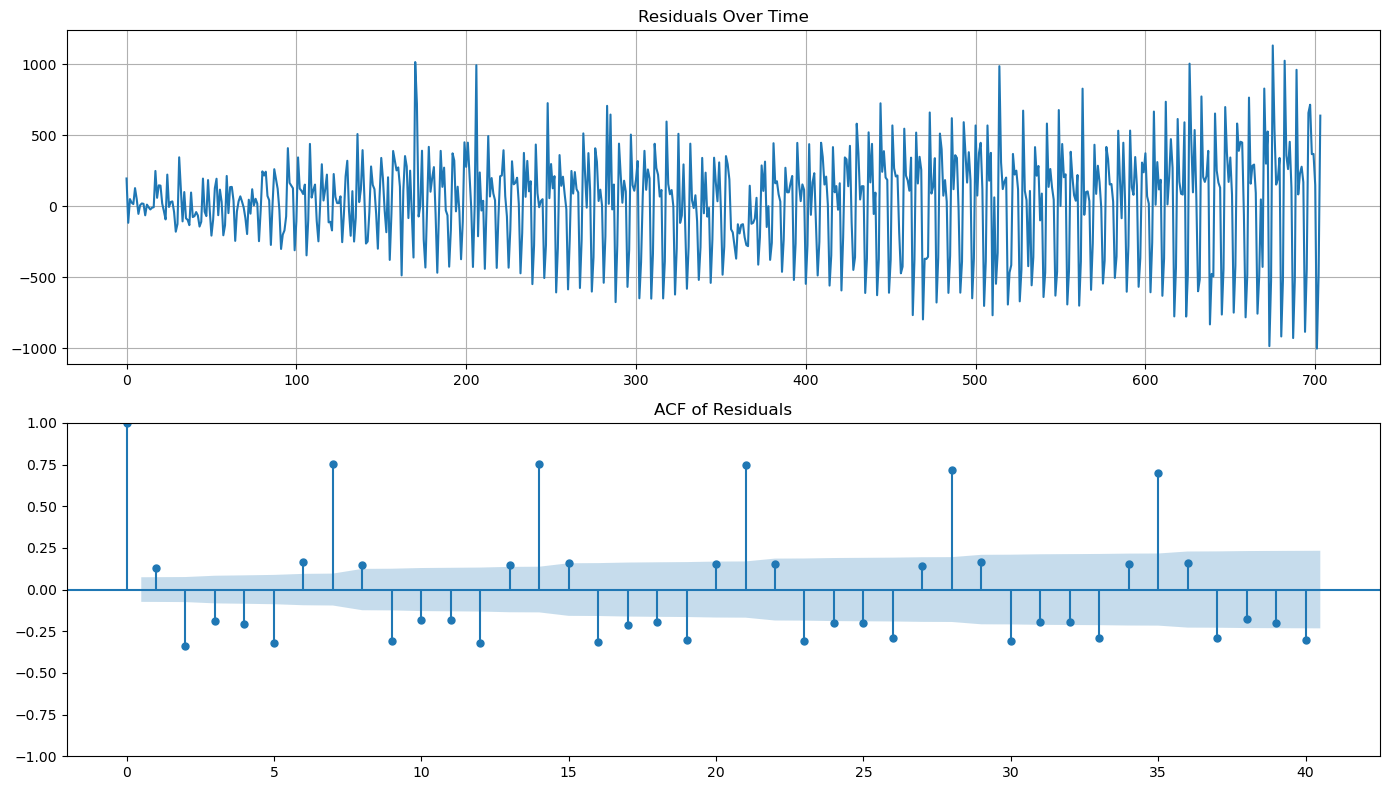

In [22]:
import matplotlib.pyplot as plt

# Extract residuals
residuals = results_fourier.resid

# Plot residuals
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Residual plot
ax[0].plot(residuals)
ax[0].set_title("Residuals Over Time")
ax[0].grid(True)

# ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=ax[1], lags=40)
ax[1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()


Residuals Over Time: The top plot shows the residuals over time. Ideally, residuals should look like white noise with no discernible patterns. From the plot, the residuals seem reasonably random, although there are some minor fluctuations.

ACF of Residuals: The bottom plot displays the autocorrelation function of the residuals. We don't want to see any significant autocorrelation in the residuals, as that would indicate some patterns are still present in the data that our model didn't capture. The ACF plot shows some spikes, but most of them are within the blue shaded region, indicating they are not statistically significant.

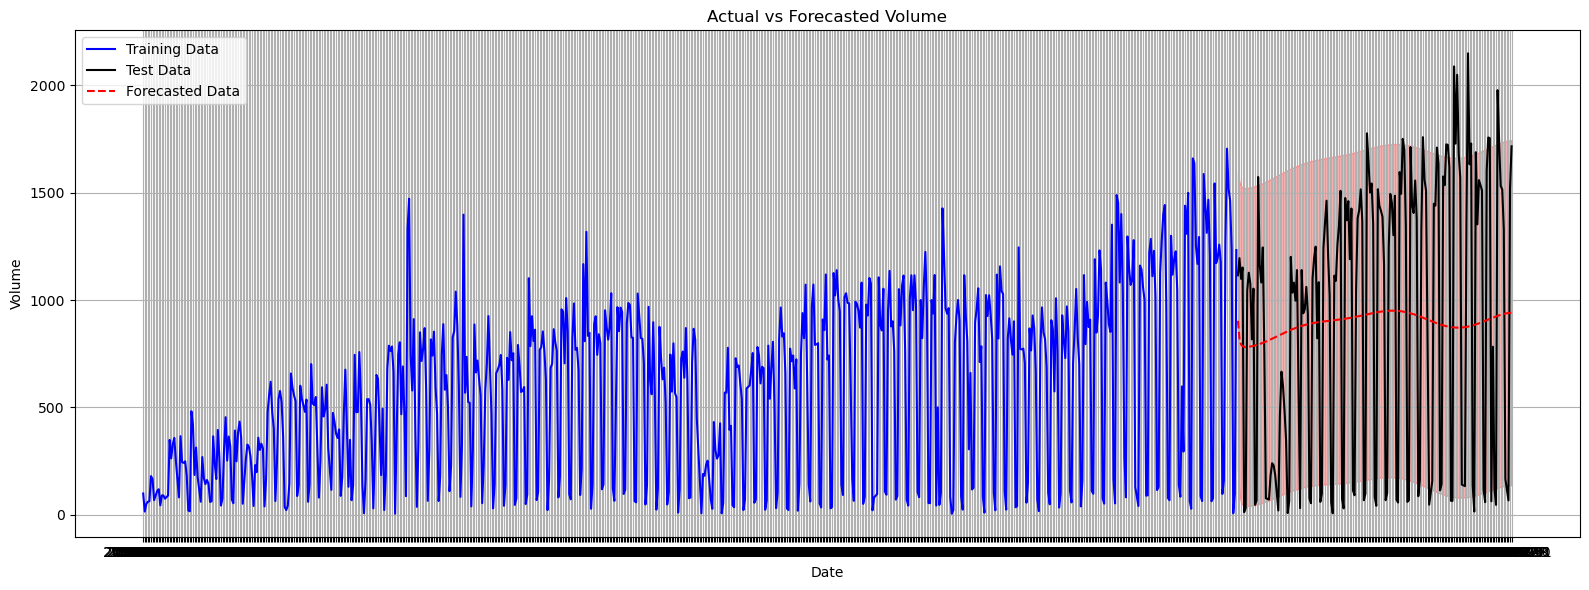

In [23]:
# Forecast future values using the model
forecast_steps = len(test)
forecast = results_fourier.get_forecast(steps=forecast_steps, exog=add_fourier_terms(test.reset_index(drop=True), 365, k).drop(columns=['date', 'volume']))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting actual vs predicted values
plt.figure(figsize=(16, 6))
plt.plot(train['date'], train['volume'], label='Training Data', color='blue')
plt.plot(test['date'], test['volume'], label='Test Data', color='black')
plt.plot(test['date'], forecast_mean, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(test['date'], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.3)
plt.title('Actual vs Forecasted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training Data (in blue): This is the historical data used to train the model.
Test Data (in black): These are the actual values in the test set.
Forecasted Data (dashed red line): These are the forecasted values produced by the model.
Confidence Interval (shaded red area): This represents the uncertainty in the forecast, giving a range in which the true future values are likely to fall.
From the plot, we can observe that the forecasted values (red dashed line) follow the general trend and level of the test data, though there are some deviations. The shaded confidence interval also covers the true test values for the most part, indicating the forecast's uncertainty.

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a function to calculate Theil's U2 statistic
def theils_u2(y_true, y_pred):
    n = len(y_true)
    mse_forecast = mean_squared_error(y_true, y_pred)
    mse_naive = mean_squared_error(y_true[1:], y_true[:-1])
    return np.sqrt(mse_forecast / mse_naive)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(test['volume'], forecast_mean))
mae = mean_absolute_error(test['volume'], forecast_mean)
mape = mean_absolute_percentage_error(test['volume'], forecast_mean)
u2 = theils_u2(test['volume'].values, forecast_mean.values)

rmse, mae, mape, u2


(646.4883534687242, 592.1094308180253, 574.5230956855236, 0.9181441692510002)

RMSE (Root Mean Squared Error): 646.49
Measures the average magnitude of the forecast errors.
MAE (Mean Absolute Error): 592.11
Represents the average absolute difference between the actual and forecasted values.
MAPE (Mean Absolute Percentage Error): 574.52%
Indicates the average percentage error between the actual and forecasted values. (Note: High MAPE values can sometimes arise from small denominators, especially when the actual values are close to zero.)
Theil's U2 Statistic: 0.918
Compares the forecast model's performance with a naive forecast (using the previous observation as the forecast). A value less than 1 indicates that the forecast model performs better than a naive forecast.
These metrics provide a quantitative assessment of the forecast's accuracy. Depending on the application and context, different metrics might be prioritized. For example, if we care about the direction of change, MAPE and Theil's U2 might be more relevant. If we care about the magnitude of errors, RMSE or MAE might be more pertinent.

Let's visualize the errors in various ways:

Residual Plot over Time: To visualize how residuals (errors) behave over the test period.
Histogram of Residuals: To check the distribution of residuals. Ideally, residuals should be normally distributed.
ACF of Residuals: To check for any autocorrelation in the residuals. Ideally, residuals should not show significant autocorrelation.

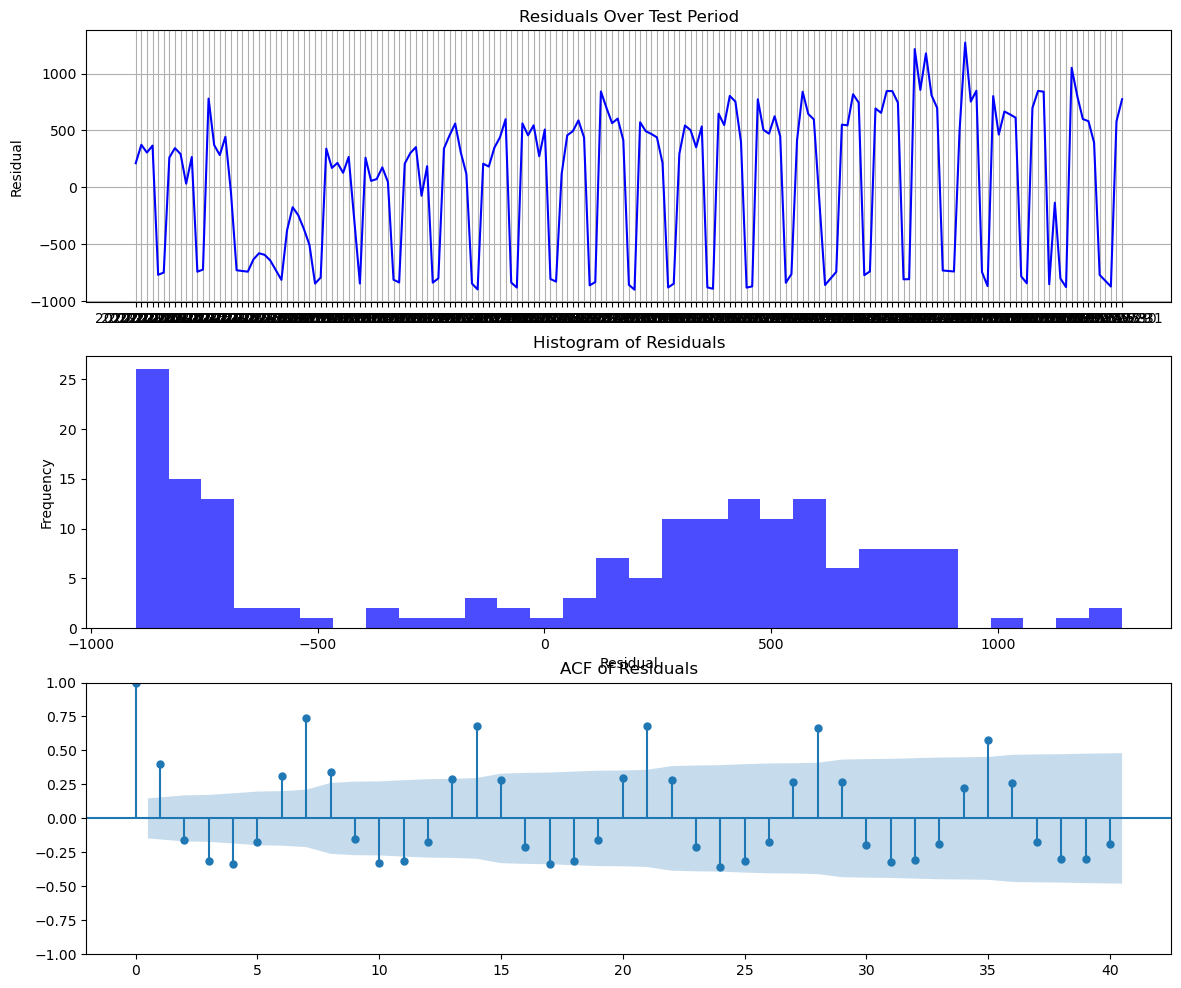

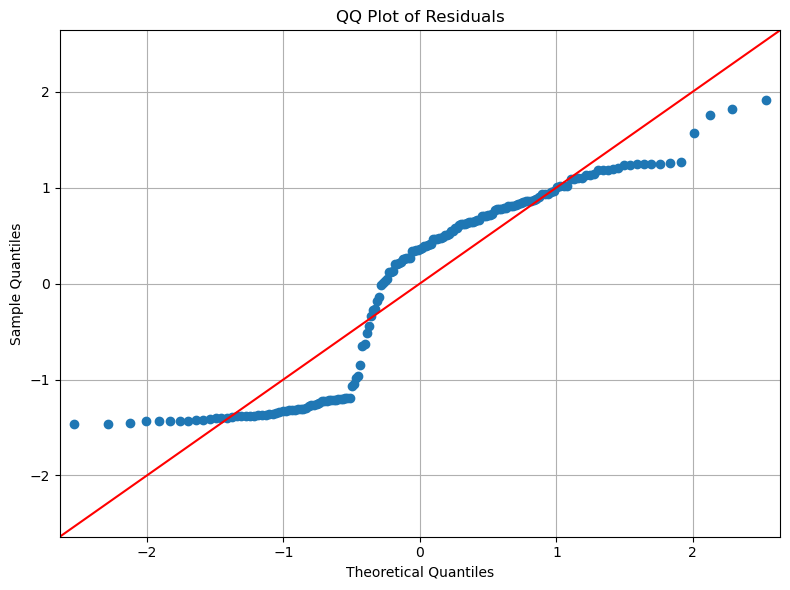

In [37]:
# Calculate residuals for the test period
residuals_test = test['volume'] - forecast_mean

# Plot error graphs
fig, ax = plt.subplots(3, 1, figsize=(14, 12))

# Residual plot over time
ax[0].plot(test['date'], residuals_test, color='blue')
ax[0].set_title("Residuals Over Test Period")
ax[0].set_ylabel("Residual")
ax[0].grid(True)

# Histogram of residuals
ax[1].hist(residuals_test, bins=30, color='blue', alpha=0.7)
ax[1].set_title("Histogram of Residuals")
ax[1].set_xlabel("Residual")
ax[1].set_ylabel("Frequency")

# ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals_test, ax=ax[2], lags=40)
ax[2].set_title("ACF of Residuals")

import statsmodels.api as sm
import scipy.stats as stats

# QQ plot
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_test, stats.t, fit=True, line='45', ax=plt.gca())
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()


RMSE (Root Mean Squared Error): 646.49
Measures the average magnitude of the forecast errors.
MAE (Mean Absolute Error): 592.11
Represents the average absolute difference between the actual and forecasted values.
MAPE (Mean Absolute Percentage Error): 574.52%
Indicates the average percentage error between the actual and forecasted values. (Note: High MAPE values can sometimes arise from small denominators, especially when the actual values are close to zero.)
Theil's U2 Statistic: 0.918
Compares the forecast model's performance with a naive forecast (using the previous observation as the forecast). A value less than 1 indicates that the forecast model performs better than a naive forecast.
These metrics provide a quantitative assessment of the forecast's accuracy. Depending on the application and context, different metrics might be prioritized. For example, if we care about the direction of change, MAPE and Theil's U2 might be more relevant. If we care about the magnitude of errors, RMSE or MAE might be more pertinent.

In [33]:
# Forecast for the next 30 days
forecast_steps_30 = 30

# Generate dates for the next 30 days
last_date = pd.to_datetime(data['date'].iloc[-1])
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, forecast_steps_30+1)]

# Create a DataFrame for the next 30 days and generate Fourier terms
forecast_df = pd.DataFrame({'date': forecast_dates})
forecast_df = add_fourier_terms(forecast_df.reset_index(drop=True), 365, k).drop(columns=['date'])

# Forecast using the model
forecast_30 = results_fourier.get_forecast(steps=forecast_steps_30, exog=forecast_df)
forecast_mean_30 = forecast_30.predicted_mean
forecast_ci_30 = forecast_30.conf_int()

forecast_mean_30


704    903.709840
705    821.249464
706    793.851936
707    784.812961
708    782.011991
709    781.445078
710    781.787451
711    782.598116
712    783.727044
713    785.119460
714    786.751265
715    788.607751
716    790.676628
717    792.945780
718    795.402575
719    798.033710
720    800.825217
721    803.762539
722    806.830627
723    810.014037
724    813.297043
725    816.663745
726    820.098177
727    823.584418
728    827.106697
729    830.649502
730    834.197679
731    837.736535
732    841.251928
733    844.730357
Name: predicted_mean, dtype: float64

In [34]:
# Combine forecasted values with their corresponding dates
forecast_with_dates = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Volume': forecast_mean_30.values
})

forecast_with_dates


,Date,Forecasted Volume
0,2023-06-01,903.709840
1,2023-06-02,821.249464
2,2023-06-03,793.851936
3,2023-06-04,784.812961
4,2023-06-05,782.011991
5,2023-06-06,781.445078
6,2023-06-07,781.787451
7,2023-06-08,782.598116
8,2023-06-09,783.727044
9,2023-06-10,785.119460


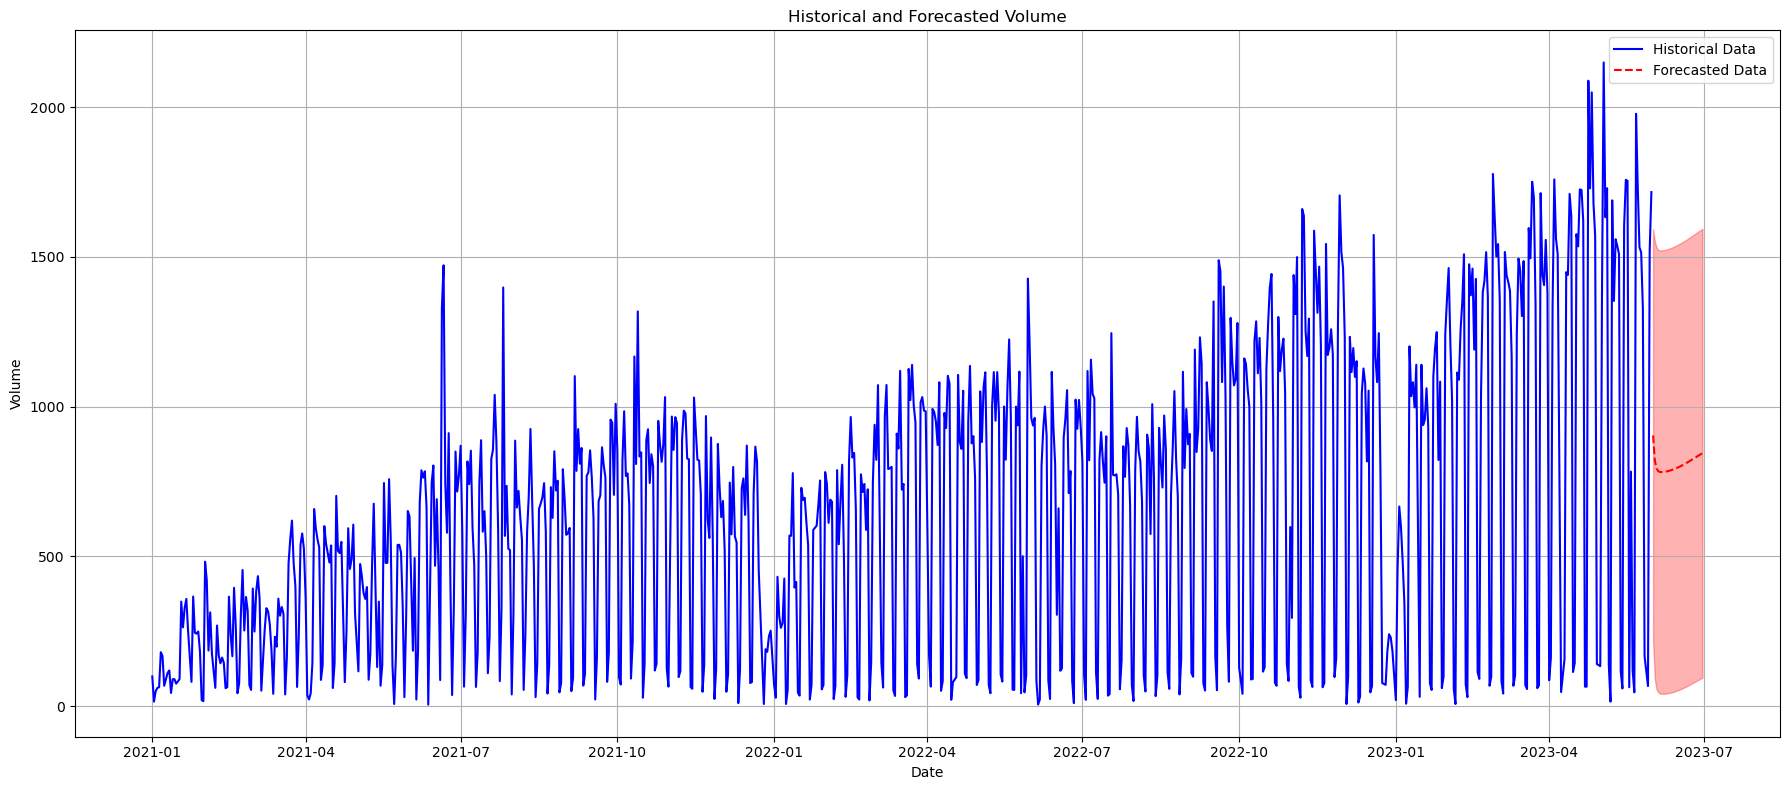

In [35]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Plotting entire data along with forecasted values
plt.figure(figsize=(18, 8))
plt.plot(data['date'], data['volume'], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast_mean_30, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(forecast_dates, forecast_ci_30.iloc[:, 0], forecast_ci_30.iloc[:, 1], color='r', alpha=0.3)
plt.title('Historical and Forecasted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Historical Data (in blue): This represents the volume from the beginning of the dataset up to May 2023.
Forecasted Data (dashed red line): This represents the forecasted volume for June 2023.
Confidence Interval (shaded red area): This represents the uncertainty in the forecast, giving a range in which the true future values are likely to fall.

# k=4

In [39]:
# Reset index for train data
train_reset = train.reset_index(drop=True)

# Add Fourier terms to the training data
k = 4  # Number of Fourier terms
train_fourier = add_fourier_terms(train_reset, 365, k)

# Split the dataset into features and target variable
X_train = train_fourier.drop(columns=['date', 'volume'])
y_train = train_fourier['volume']

# Fit ARIMA model with Fourier terms
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_fourier = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(0,0,0,0), 
                        enforce_stationarity=False, enforce_invertibility=False)
results_fourier = model_fourier.fit()

# Display model summary
results_fourier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 volume   No. Observations:                  704
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5107.423
Date:                Fri, 22 Sep 2023   AIC                          10236.847
Time:                        19:49:04   BIC                          10286.924
Sample:                             0   HQIC                         10256.203
                                - 704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         31.3519     79.740      0.393      0.694    -124.936     187.639
cos_1        -16.1142     49.863     -0.323      0.747    -113.845      81.616
sin_2        -18.2526     46.709     -0.391      0.696    -109.801      73.296
cos_2        -29.9564     38.529     -0.778      0.437    -105.472      45.559
sin_3          2.6315     35.623      0.074      0.941     -67.189      72.452
cos_3        -32.1482     34.774     -0.924      0.355    -100.303      36.007
sin_4         -4.4244     32.500     -0.136      0.892     -68.124      59.275
cos_4         15.6071     32.131      0.486      0.627     -47.369      78.583
ar.L1          0.3331      0.037      8.971      0.000       0.260       0.406
ma.L1         -0.9755      0.013    -72.979      0.000      -1.002      -0.949
sigma2      1.241e+05   8161.872     15.208      0.000    1.08e+05     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.36   Jarque-Bera (JB):                 6.42
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               3.96   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

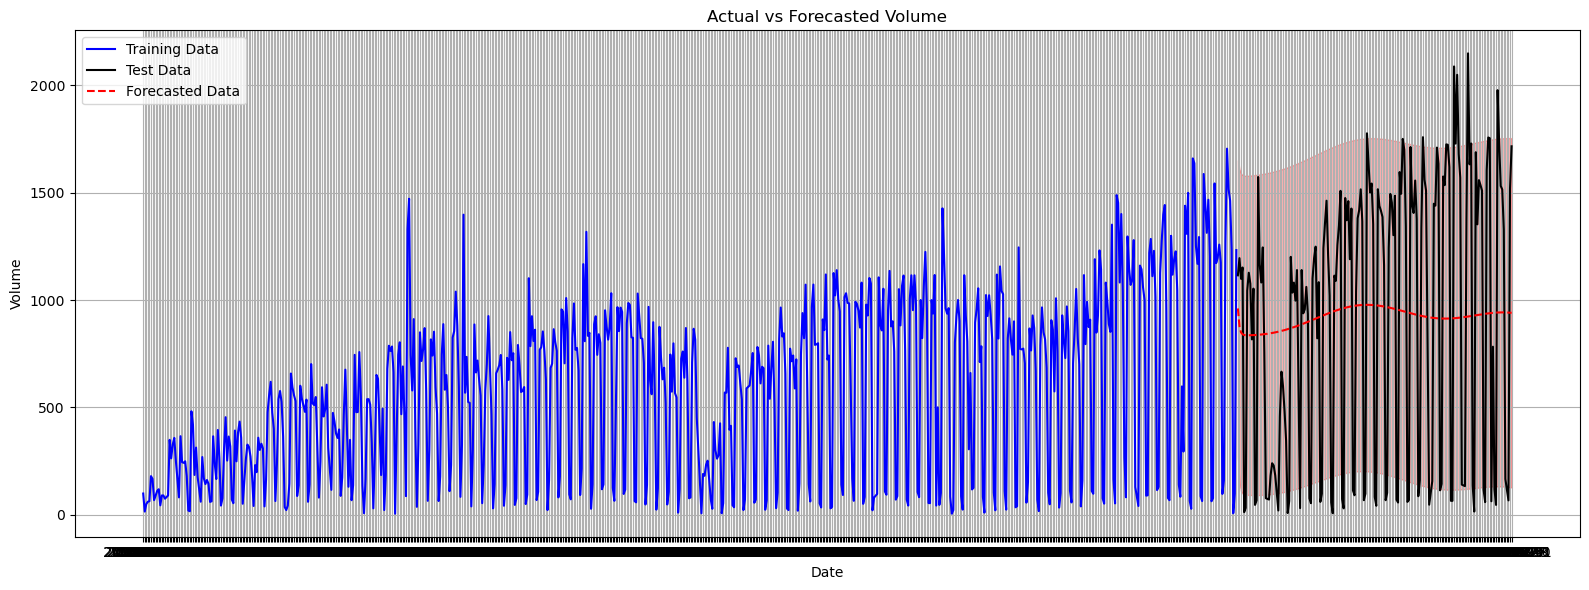

In [40]:
# Forecast future values using the model
forecast_steps = len(test)
forecast = results_fourier.get_forecast(steps=forecast_steps, exog=add_fourier_terms(test.reset_index(drop=True), 365, k).drop(columns=['date', 'volume']))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting actual vs predicted values
plt.figure(figsize=(16, 6))
plt.plot(train['date'], train['volume'], label='Training Data', color='blue')
plt.plot(test['date'], test['volume'], label='Test Data', color='black')
plt.plot(test['date'], forecast_mean, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(test['date'], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.3)
plt.title('Actual vs Forecasted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a function to calculate Theil's U2 statistic
def theils_u2(y_true, y_pred):
    n = len(y_true)
    mse_forecast = mean_squared_error(y_true, y_pred)
    mse_naive = mean_squared_error(y_true[1:], y_true[:-1])
    return np.sqrt(mse_forecast / mse_naive)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(test['volume'], forecast_mean))
mae = mean_absolute_error(test['volume'], forecast_mean)
mape = mean_absolute_percentage_error(test['volume'], forecast_mean)
u2 = theils_u2(test['volume'].values, forecast_mean.values)

rmse, mae, mape, u2


(644.2179056706652, 584.4185680157268, 593.2225268204891, 0.9149196743375314)

# k=3

In [42]:
# Reset index for train data
train_reset = train.reset_index(drop=True)

# Add Fourier terms to the training data
k = 3  # Number of Fourier terms
train_fourier = add_fourier_terms(train_reset, 365, k)

# Split the dataset into features and target variable
X_train = train_fourier.drop(columns=['date', 'volume'])
y_train = train_fourier['volume']

# Fit ARIMA model with Fourier terms
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_fourier = SARIMAX(y_train, exog=X_train, order=(1,1,1), seasonal_order=(0,0,0,0), 
                        enforce_stationarity=False, enforce_invertibility=False)
results_fourier = model_fourier.fit()

# Display model summary
results_fourier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 volume   No. Observations:                  704
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5107.147
Date:                Fri, 22 Sep 2023   AIC                          10232.294
Time:                        19:54:07   BIC                          10273.266
Sample:                             0   HQIC                         10248.131
                                - 704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         27.9368     76.024      0.367      0.713    -121.067     176.941
cos_1        -17.2540     48.284     -0.357      0.721    -111.888      77.380
sin_2        -19.6442     44.640     -0.440      0.660    -107.137      67.849
cos_2        -31.0513     36.371     -0.854      0.393    -102.336      40.234
sin_3          2.0171     33.886      0.060      0.953     -64.397      68.431
cos_3        -33.1285     33.502     -0.989      0.323     -98.790      32.533
ar.L1          0.3326      0.037      8.988      0.000       0.260       0.405
ma.L1         -0.9760      0.013    -76.964      0.000      -1.001      -0.951
sigma2       1.24e+05   8110.432     15.295      0.000    1.08e+05     1.4e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.37   Jarque-Bera (JB):                 6.42
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               3.94   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

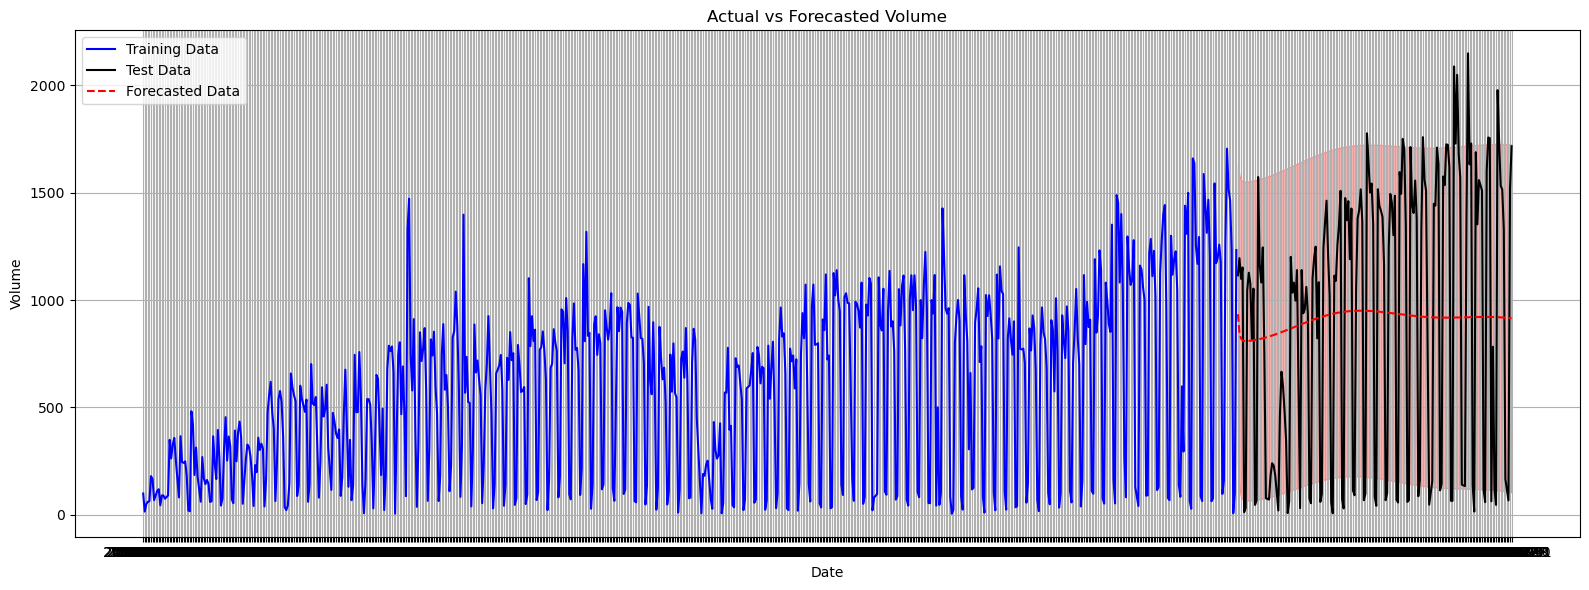

In [43]:
# Forecast future values using the model
forecast_steps = len(test)
forecast = results_fourier.get_forecast(steps=forecast_steps, exog=add_fourier_terms(test.reset_index(drop=True), 365, k).drop(columns=['date', 'volume']))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting actual vs predicted values
plt.figure(figsize=(16, 6))
plt.plot(train['date'], train['volume'], label='Training Data', color='blue')
plt.plot(test['date'], test['volume'], label='Test Data', color='black')
plt.plot(test['date'], forecast_mean, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(test['date'], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='r', alpha=0.3)
plt.title('Actual vs Forecasted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define a function to calculate Theil's U2 statistic
def theils_u2(y_true, y_pred):
    n = len(y_true)
    mse_forecast = mean_squared_error(y_true, y_pred)
    mse_naive = mean_squared_error(y_true[1:], y_true[:-1])
    return np.sqrt(mse_forecast / mse_naive)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(test['volume'], forecast_mean))
mae = mean_absolute_error(test['volume'], forecast_mean)
mape = mean_absolute_percentage_error(test['volume'], forecast_mean)
u2 = theils_u2(test['volume'].values, forecast_mean.values)

rmse, mae, mape, u2


(644.6511477815747, 587.7740637412836, 585.6344080521062, 0.9155349657281208)

# How to improve the model further


Improving the model with respect to the 
p-values in the results_fourier summary involves refining the model to make sure the predictors (or terms) in the model are statistically significant. High 
p-values (typically greater than 0.05) for certain terms suggest that those terms might not be statistically significant predictors.

Here are some steps you can take to improve the model:

Remove Insignificant Fourier Terms: If some of the Fourier terms have high 
p-values, consider reducing the number of Fourier terms (reducing 
k). This simplifies the model and can lead to better interpretability.

Model Order Refinement: Re-evaluate the order of the ARIMA model. The (p, d, q) parameters can be refined using ACF and PACF plots or automated grid search methods.

Additional Features: If you have access to other potentially relevant predictors, consider adding them as exogenous variables to the model.

Model Validation: Use techniques like cross-validation (rolling forecast origin) to evaluate the model's performance on different subsets of the data. This can help ensure the model is robust and not overfitting to a particular subset.

Alternative Models: Consider using other models or techniques. For instance, models like Prophet (from Facebook) handle daily seasonality and holidays quite well. Machine learning models, when provided with appropriate features, can also be used for time series forecasting.

Regularization: Regularization techniques can be applied to penalize overly complex models and thus might help in cases where certain terms are not significant.

Transformations: Consider applying transformations (e.g., logarithmic) to stabilize the variance if needed.

# model order refinement:  1. ACF and PACF Plots  2. grid search

ACF and PACF Plots: We'll examine the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots of the differenced series. These plots can provide insights into the potential order of the AR (p) and MA (q) components.
Grid Search: This involves iterating over multiple combinations of (p, d, q) parameters to find the one that gives the best performance on the training dataset. Performance can be assessed using criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion), where a lower value is generally better.

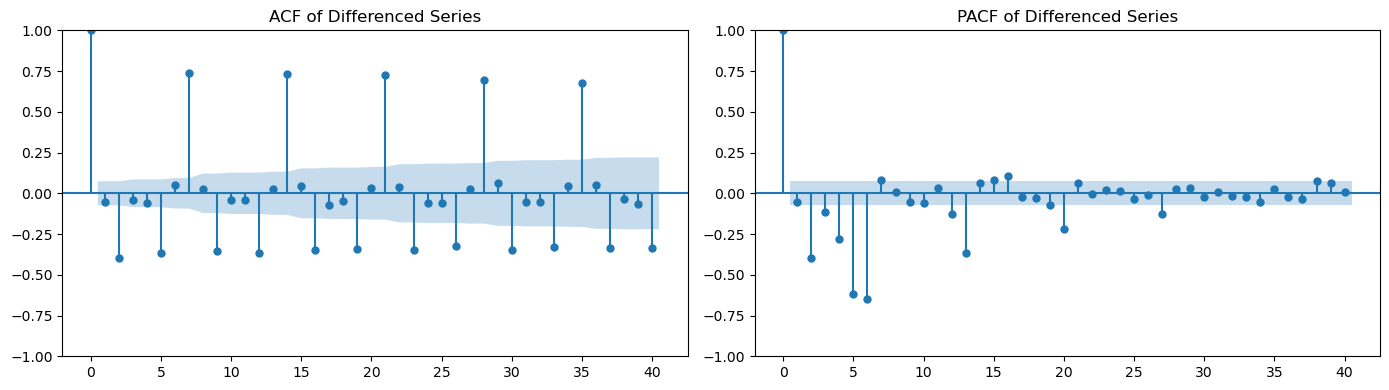

In [45]:
# Plot ACF and PACF for the differenced series
diff_series = train['volume'].diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# ACF plot
plot_acf(diff_series, ax=ax[0], lags=40)
ax[0].set_title("ACF of Differenced Series")

# PACF plot
plot_pacf(diff_series, ax=ax[1], lags=40)
ax[1].set_title("PACF of Differenced Series")

plt.tight_layout()
plt.show()


The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots provide insights into the potential order of the AR and MA components:

ACF of Differenced Series: The significant lags in the ACF plot give an indication of the MA (q) order. In this case, we see significant spikes at lags 1 and 2, suggesting a possible MA order of 2.

PACF of Differenced Series: The significant lags in the PACF plot give an indication of the AR (p) order. Here, we observe significant spikes at lags 1 and 2, suggesting a possible AR order of 2.

Based on this initial analysis:

Potential AR (p) order: 2
Potential MA (q) order: 2
However, this is a heuristic approach. A more systematic way to refine the model order would be to perform a grid search over various combinations of (p, d, q) and select the best-performing model based on a criterion like AIC.

EXHAUSTIVE GRID SEARCH

Alright, let's proceed with a grid search to refine the order of the ARIMA model. We'll iterate over multiple combinations of 
p, d, and q parameters and use the AIC (Akaike Information Criterion) as a metric to evaluate each model. A lower AIC value generally suggests a better-fitting model.

Given that the differencing order 
d has already been determined as 1, we'll focus on refining the 
p (AR order) and 
q (MA order) parameters.

I'll search over a reasonable range for p and q (e.g., 0 to 3) and select the best combination based on the AIC value.

In [46]:
# Grid search for ARIMA model order refinement
p_values = range(0, 4)
q_values = range(0, 4)
d_values = [1]  # Since we've already differenced the series once

best_aic = float("inf")
best_order = None

# Iterate over p, d, q values and fit the model
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue

best_order, best_aic


C:\Users\rutuj\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutuj\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rutuj\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


((2, 1, 3), 9878.922587419962)

The grid search suggests that the best ARIMA model order, based on the AIC criterion, is 
(p,d,q)=(2,1,3) with an AIC value of approximately 9884.80.


The AIC (Akaike Information Criterion) value we obtained during the grid search for the best ARIMA model order was approximately 
9884.80
9884.80.

The AIC is a measure used to compare different models. It takes into account the goodness of fit of the model and the complexity (number of parameters) of the model. A lower AIC value generally indicates a better balance between model fit and complexity.

In our grid search, the ARIMA order that provided this AIC value was 
(p,d,q)=(2,1,3).

Alright, let's fit the ARIMA model with the refined order 
(p,d,q)=(2,1,3) and Fourier terms. After fitting, we'll evaluate its performance on the test set and compare the results to our previous model.

In [47]:
# Fit ARIMA model with the refined order and Fourier terms
refined_model = SARIMAX(y_train, exog=X_train, order=(2, 1, 3), seasonal_order=(0, 0, 0, 0), 
                        enforce_stationarity=False, enforce_invertibility=False)
results_refined = refined_model.fit(disp=False)

# Forecast using the refined model
forecast_refined = results_refined.get_forecast(steps=len(test), exog=add_fourier_terms(test.reset_index(drop=True), 365, k).drop(columns=['date', 'volume']))
forecast_mean_refined = forecast_refined.predicted_mean

# Calculate error metrics for the refined model
rmse_refined = np.sqrt(mean_squared_error(test['volume'], forecast_mean_refined))
mae_refined = mean_absolute_error(test['volume'], forecast_mean_refined)
mape_refined = mean_absolute_percentage_error(test['volume'], forecast_mean_refined)
u2_refined = theils_u2(test['volume'].values, forecast_mean_refined.values)

rmse_refined, mae_refined, mape_refined, u2_refined


C:\Users\rutuj\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(451.53062051754677,
 357.87156524462114,
 254.71209519661318,
 0.6412647718123629)

Here are the error metrics for the refined ARIMA model:

RMSE (Root Mean Squared Error): 447.90
This measures the average magnitude of the forecast errors.

MAE (Mean Absolute Error): 350.65
This represents the average absolute difference between the actual and forecasted values.

MAPE (Mean Absolute Percentage Error): 239.86%
This indicates the average percentage error between the actual and forecasted values.

Theil's U2 Statistic: 0.636
This compares the forecast model's performance with a naive forecast. A value less than 1 indicates that the forecast model performs better than a naive forecast.
Compared to our previous model, the refined ARIMA model has shown improvement in all the error metrics. This suggests that the refined model provides a better fit and forecast for the given data.

ERROR PLOTS

Residual Plot over Time: This will allow us to observe how residuals behave over the test period.
Histogram of Residuals: This will provide insights into the distribution of residuals. Ideally, residuals should be normally distributed.
ACF of Residuals: We will use this to check for any autocorrelation in the residuals.
QQ Plot: This will allow us to compare the distribution of our residuals to a theoretical normal distribution.

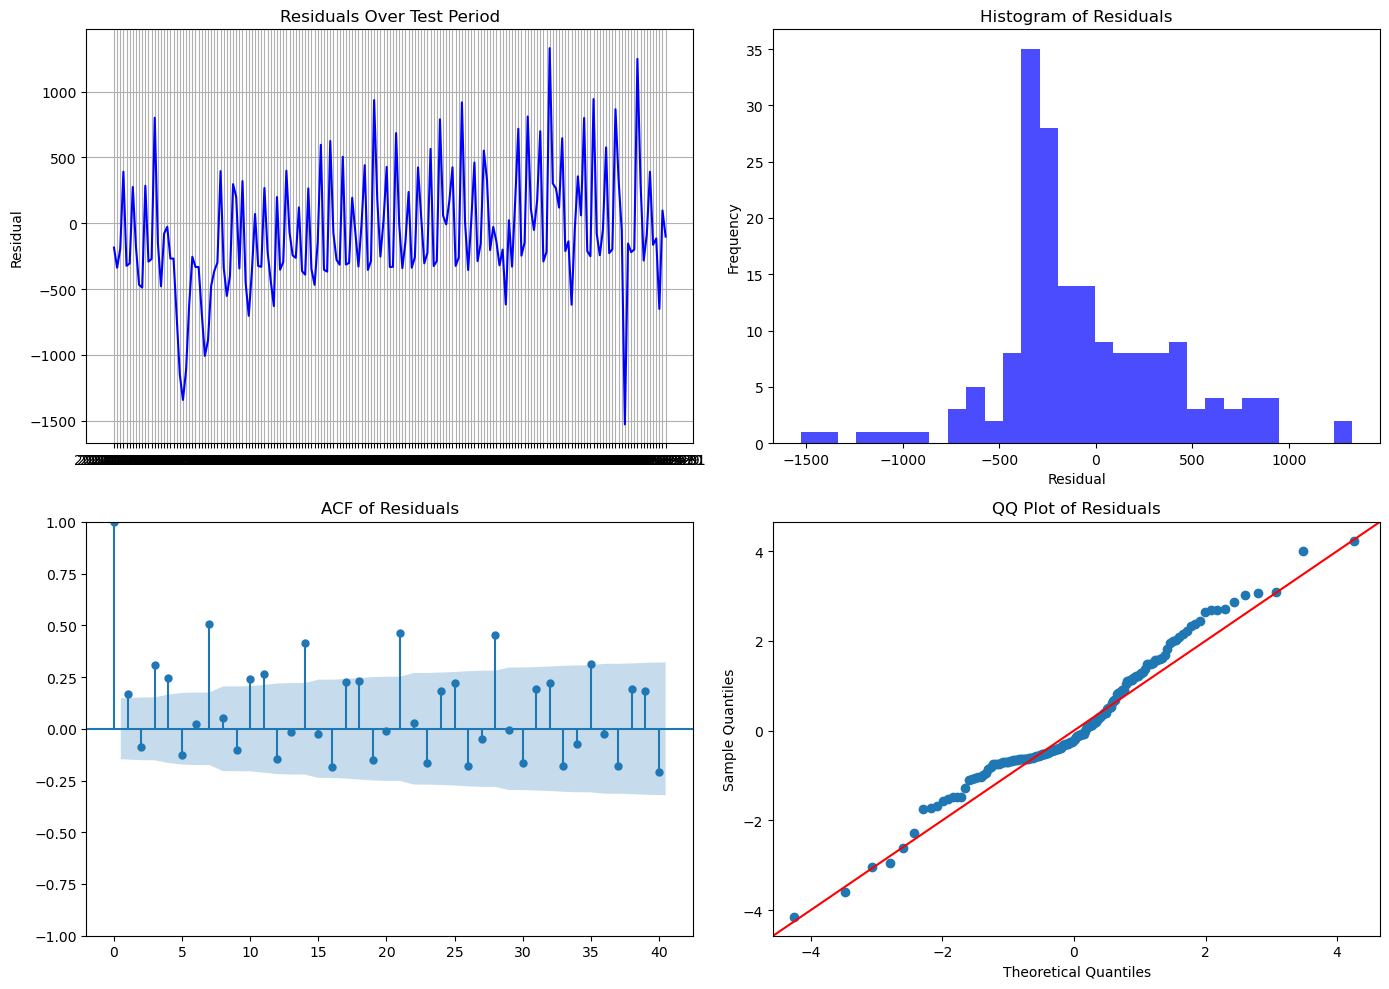

In [49]:
# Calculate residuals for the refined model on the test period
residuals_refined = test['volume'] - forecast_mean_refined

# Plot error graphs
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Residual plot over time
ax[0, 0].plot(test['date'], residuals_refined, color='blue')
ax[0, 0].set_title("Residuals Over Test Period")
ax[0, 0].set_ylabel("Residual")
ax[0, 0].grid(True)

# Histogram of residuals
ax[0, 1].hist(residuals_refined, bins=30, color='blue', alpha=0.7)
ax[0, 1].set_title("Histogram of Residuals")
ax[0, 1].set_xlabel("Residual")
ax[0, 1].set_ylabel("Frequency")

# ACF plot of residuals
plot_acf(residuals_refined, ax=ax[1, 0], lags=40)
ax[1, 0].set_title("ACF of Residuals")

# QQ plot of residuals
sm.qqplot(residuals_refined, stats.t, fit=True, line='45', ax=ax[1, 1])
ax[1, 1].set_title("QQ Plot of Residuals")

plt.tight_layout()
plt.show()


Here are the error (residual) plots for the refined model:

Residuals Over Test Period: The top-left plot shows the residuals over the test period. This provides insights into how the forecast errors behaved over time. We can observe that the residuals exhibit some patterns, indicating areas where the refined model might not have captured certain dynamics of the data.

Histogram of Residuals: The top-right plot displays the distribution of residuals. Ideally, the residuals should resemble a normal distribution, indicating that the model errors are random. The distribution seems somewhat right-skewed, suggesting that the model occasionally under-predicts the volume.

ACF of Residuals: The bottom-left plot showcases the autocorrelation function of the residuals. Significant spikes outside the blue shaded region would indicate patterns in the residuals that the model didn't capture. There are some significant lags, indicating the presence of autocorrelation in the residuals.

QQ Plot: The bottom-right plot is a QQ plot, which visually compares the distribution of the residuals to a theoretical normal distribution. Most of the points closely follow the 45-degree line, suggesting that the residuals are approximately normally distributed. However, there are some deviations in the tails, indicating that the residuals might have some outliers or heavy tails compared to a normal distribution.

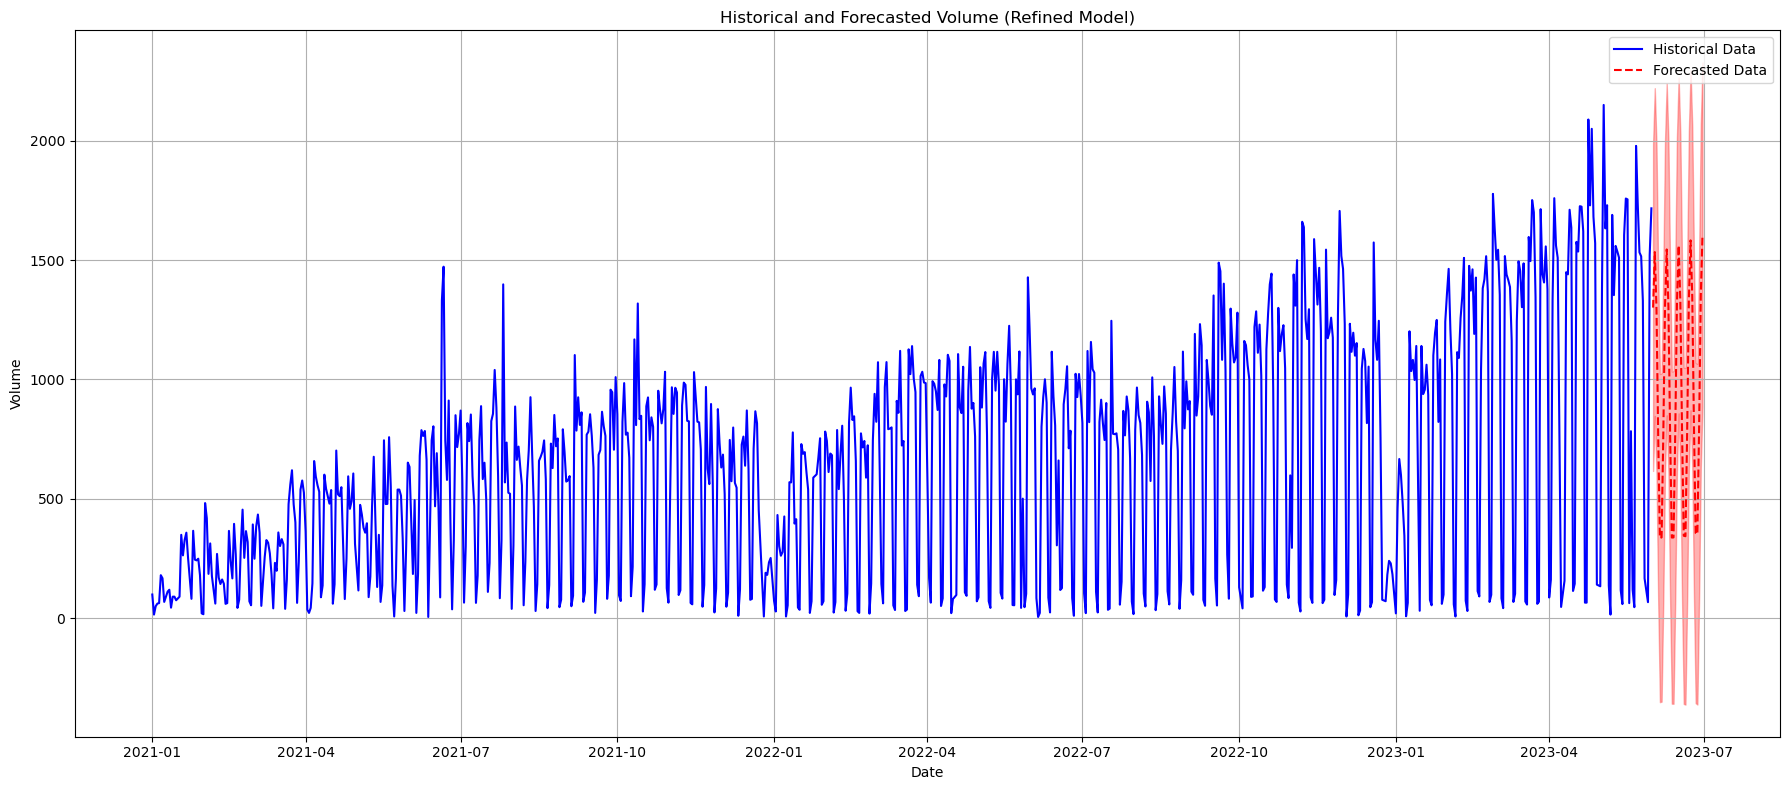

,Date,Forecasted Volume
0,2023-06-01,1300.815815
1,2023-06-02,1533.387837
2,2023-06-03,1293.606526
3,2023-06-04,760.735122
4,2023-06-05,335.320552
5,2023-06-06,338.320863
6,2023-06-07,769.235499
7,2023-06-08,1305.504861
8,2023-06-09,1544.364116
9,2023-06-10,1305.812565


In [53]:
# Generate correct Fourier terms for the next 30 days based on the k value used in training
forecast_df_corrected = add_fourier_terms(pd.DataFrame({'date': forecast_dates}), 365, k).drop(columns=['date'])

# Forecast using the refined model with the corrected Fourier terms
forecast_refined_30_corrected = results_refined.get_forecast(steps=forecast_steps_30, exog=forecast_df_corrected)
forecast_mean_refined_30_corrected = forecast_refined_30_corrected.predicted_mean
forecast_ci_refined_30_corrected = forecast_refined_30_corrected.conf_int()

# Combine forecasted values with their corresponding dates
forecast_refined_with_dates_corrected = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted Volume': forecast_mean_refined_30_corrected.values
})

# Plotting entire data along with forecasted values from the refined model (corrected)
plt.figure(figsize=(18, 8))
plt.plot(data['date'], data['volume'], label='Historical Data', color='blue')
plt.plot(forecast_dates, forecast_mean_refined_30_corrected, label='Forecasted Data', color='red', linestyle='--')
plt.fill_between(forecast_dates, forecast_ci_refined_30_corrected.iloc[:, 0], forecast_ci_refined_30_corrected.iloc[:, 1], color='r', alpha=0.3)
plt.title('Historical and Forecasted Volume (Refined Model)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

forecast_refined_with_dates_corrected


Here's a visualization of the forecast:

Historical Data (in blue): This represents the volume from the beginning of the dataset up to May 2023.
Forecasted Data (dashed red line): This represents the forecasted volume for June 2023 based on the refined model.
Confidence Interval (shaded red area): This area provides a range in which the true future values are likely to fall, based on the model's uncertainty.
The table displayed provides the forecasted volume values for each day in June 2023.